# TDC - bbb-martins dataset curation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[2]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
org = "polaris"
data_name = "bbb-martins"
dirname = dm.fs.join(root, f"org-{org}/tdc", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/tdc/{data_name}"

## Load the raw data
The dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955

In [3]:
# Load the data
from tdc.single_pred import ADME

data = ADME(name="BBB_Martins")
split = data.get_split()
split.keys()

Found local copy...
Loading...
Done!


dict_keys(['train', 'valid', 'test'])

In [4]:
# concate the splits into one table for curation step
data = pd.DataFrame()
for split_key in split.keys():
    split_df = split[split_key]
    split_df["split"] = split_key
    data = pd.concat([data, split_df], ignore_index=True)

data

,Drug_ID,Drug,Y,split
0,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,train
1,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,train
2,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,train
3,cefoperazone,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=...,1,train
4,rolitetracycline,CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]...,1,train
...,...,...,...,...
2025,rifamide,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,0,test
2026,BRL52871,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,1,test
2027,hydromorphone,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,1,test
2028,suritozole,Cn1nc(-c2cccc(F)c2)n(C)c1=S,1,test


In [5]:
data.split.value_counts()

split
train    1421
test      406
valid     203
Name: count, dtype: int64

In [6]:
# Define key columns for curation
mol_col = "Drug"
data_cols = ["Y"]

In [7]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import (
    MoleculeCuration,
    OutlierDetection,
    Deduplication,
    StereoIsomerACDetection,
    Discretization,
)

# Define the curation workflow
curator = Curator(
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        StereoIsomerACDetection(y_cols=data_cols),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

curator.to_json(f"{dirname}/inspection_config.json")

In [8]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-07-29 12:08:40.821 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-29 12:09:01.539 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [9]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-29 12:08:40
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 688.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== ac_stereoisomer =====
[LOG]: New column added: AC_Y
[LOG]: Found 29 activity cliffs among stereoisomers with respect to the Y column.
[LOG]: The molecule index are : 1648 ,1317 ,1970 ,183 ,257 ,1547 ,1582 ,690 ,1133 ,121 ,210 ,1698 ,

In [10]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

In [11]:
# check the curated data
data_inspection.describe(include="all")

,Drug_ID,Drug,Y,split,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,AC_Y
count,2030,2030,2030.000000,2030,2030,2030,2030,2.030000e+03,2.030000e+03,2030.000000,2030.000000,2030.000000,2030,2030.0,2030
unique,2018,1975,NaN,3,1968,1968,1945,NaN,NaN,NaN,NaN,NaN,2,1.0,2
top,Org5222,CNCCc1ccccn1,NaN,train,CN(C)CCc1ccccn1,b677426dfe1e4f16924f34bf8c8d207a057003fd,7d7dc0bf4674925c690152f81cd6c976a3374d27,NaN,NaN,NaN,NaN,NaN,False,0.0,False
freq,2,3,NaN,1421,3,3,3,NaN,NaN,NaN,NaN,NaN,1474,2030.0,2001
mean,NaN,NaN,0.764039,NaN,NaN,NaN,NaN,1.914946e+05,1.413977e+03,1.437438,0.742365,2.179803,NaN,NaN,NaN
std,NaN,NaN,0.424702,NaN,NaN,NaN,NaN,6.188091e+06,4.801499e+04,3.043593,1.790157,3.456793,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,NaN,NaN,NaN
75%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,8.000000e+00,2.000000e+00,2.000000,1.000000,3.000000,NaN,NaN,NaN


### Check the activity shift between the stereo isomers

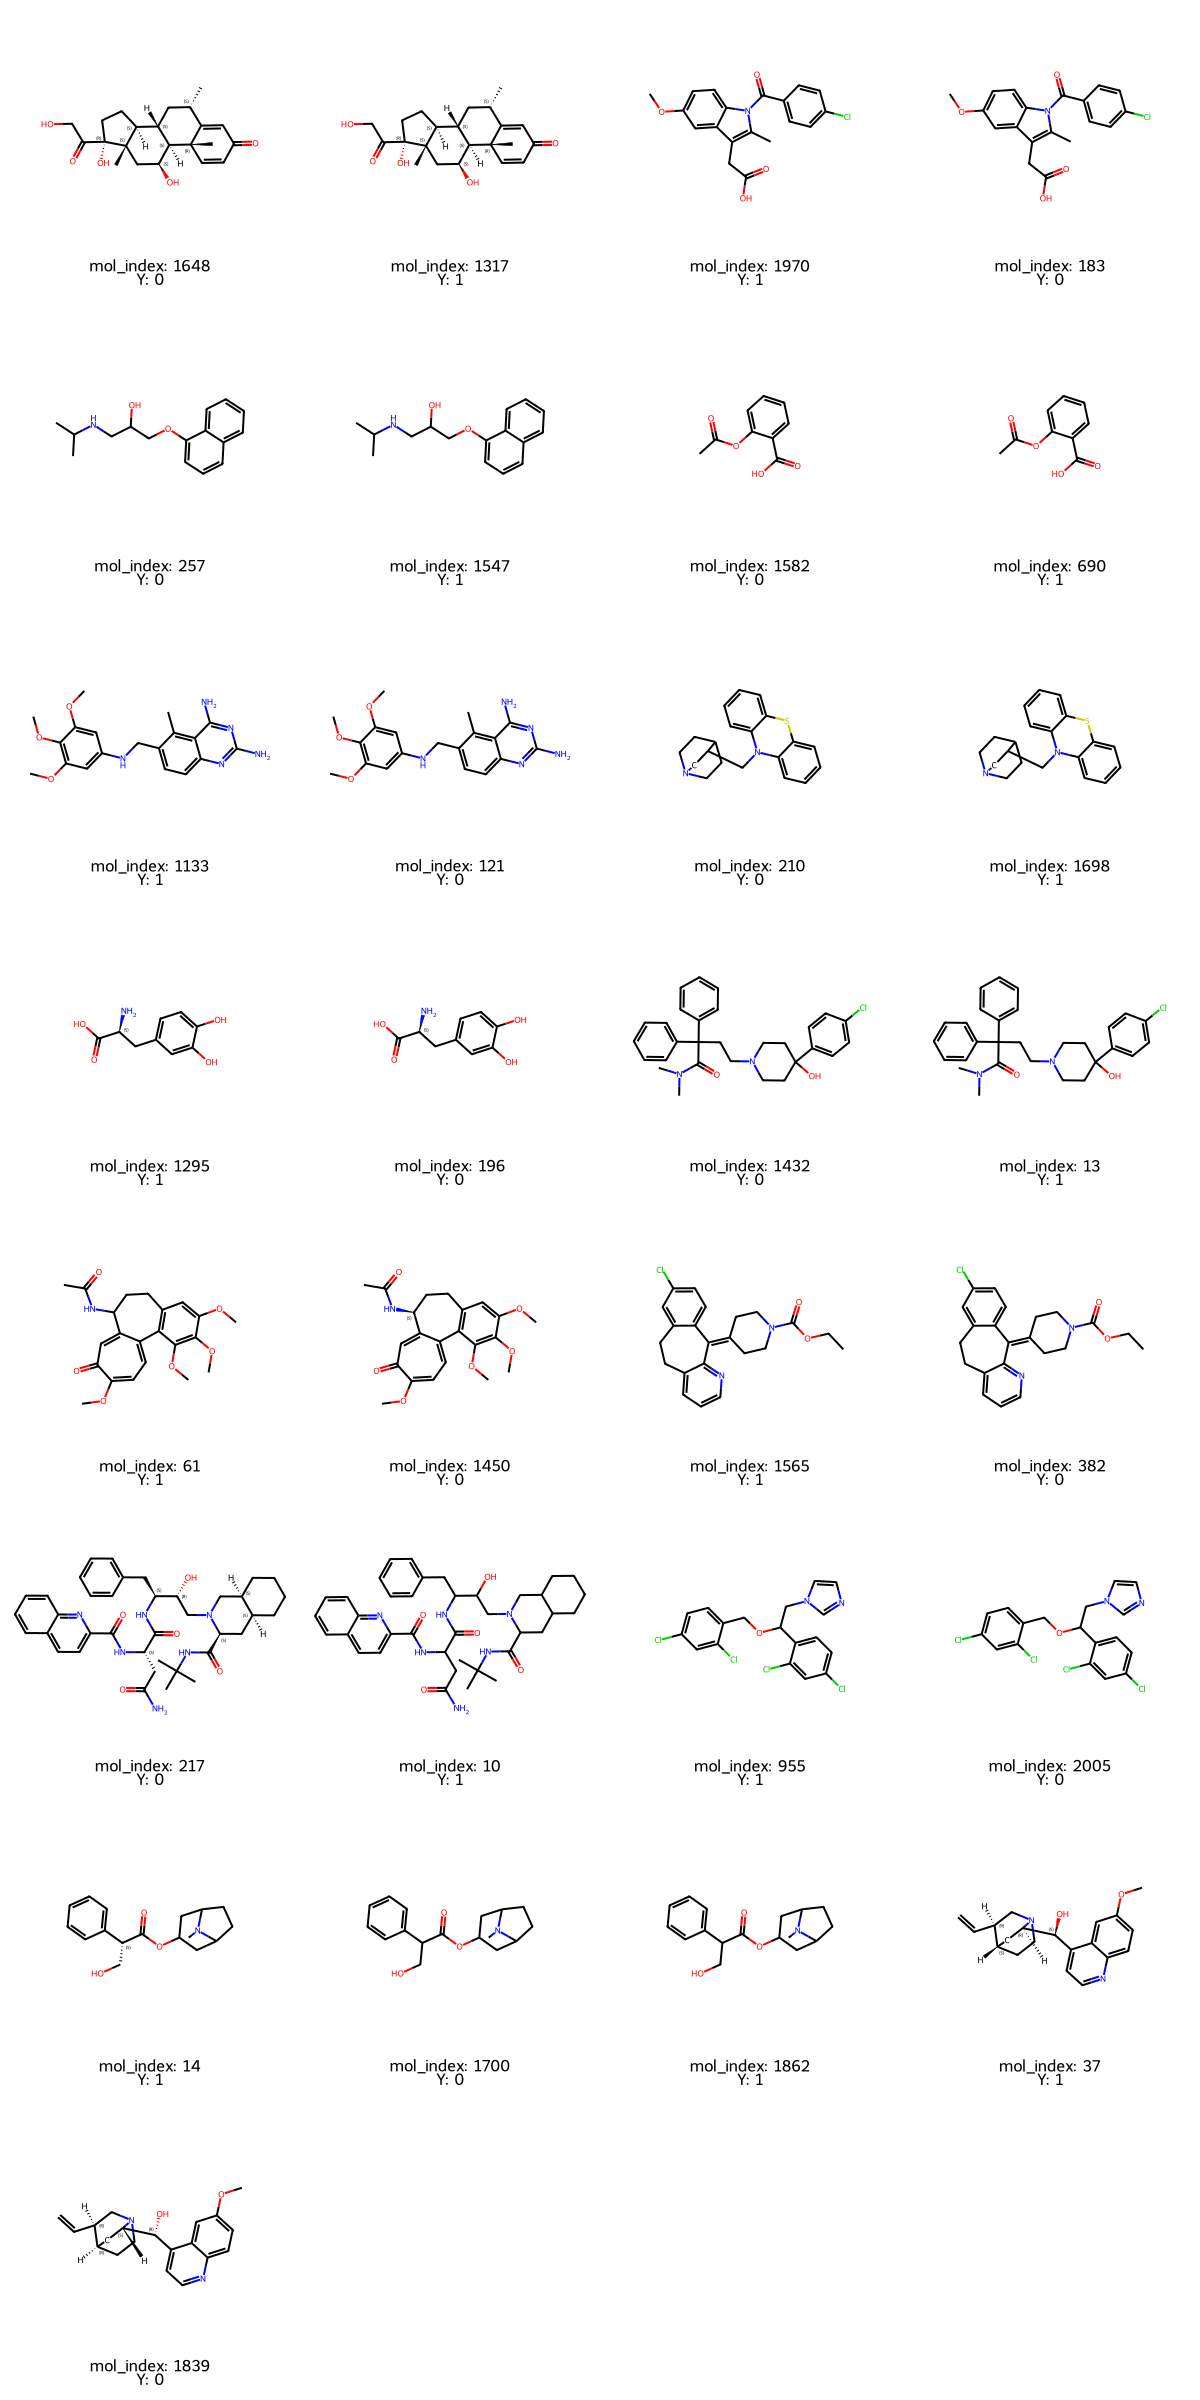

In [12]:
# Check the stereoisomers and duplicated molecules
index_inspect = [
    1648,
    1317,
    1970,
    183,
    257,
    1547,
    1582,
    690,
    1133,
    121,
    210,
    1698,
    1295,
    196,
    1432,
    13,
    61,
    1450,
    1565,
    382,
    217,
    10,
    955,
    2005,
    14,
    1700,
    1862,
    37,
    1839,
]
data.iloc[index_inspect]

,Drug_ID,Drug,Y,split
1648,Methylprednisolone,C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(...,0,test
1317,methylprednisolone,C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(...,1,train
1970,indomethacin(indometacin),COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,1,test
183,indomethacin,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,0,train
257,propranolol,CC(C)NCC(O)COc1cccc2ccccc12,0,train
1547,Propanolol,CC(C)NCC(O)COc1cccc2ccccc12.[Cl],1,valid
1582,acetylsalicylate,CC(=O)Oc1ccccc1C(=O)O,0,valid
690,aspirin,CC(=O)Oc1ccccc1C(=O)O,1,train
1133,trimetrexate,COc1cc(NCc2ccc3nc(N)nc(N)c3c2C)cc(OC)c1OC,1,train
121,Trimetrexate,COc1cc(NCc2ccc3nc(N)nc(N)c3c2C)cc(OC)c1OC,0,train


The dataset reveals that 29 molecules are present in both the train, valid and test sets, each assigned different class labels. 
These inconsistencies can significantly impact model training and evaluation, diminishing the benchmark's reliability. 
Therefore, these molecules should be excluded from the dataset.

In [13]:
# mask clf value for #309
data = data.drop(index=index_inspect).reset_index(drop=True)
data.describe()

,Y
count,2001.000000
mean,0.767616
std,0.422458
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Rerun data curation and export curated data for downstream tasks


### Rerun the curation steps

In [14]:
curator = Curator(
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        StereoIsomerACDetection(y_cols=data_cols),
        Deduplication(
            deduplicate_on=mol_col, y_cols=data_cols
        ),  # remove the replicated molecules
    ],
    parallelized_kwargs={"n_jobs": -1},
)

# The final curation configuration is exported for reproducibility
path = f"{gcp_root}/data/curation/curation_config.json"
curator.to_json(path)

In [15]:
# Run the curation step defined as above
data_curated, report = curator(data)

2024-07-29 12:09:11.302 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-29 12:09:17.917 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer
2024-07-29 12:09:18.044 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate


In [ ]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(
    report, f"{gcp_root}/data/curation/report", embed_images=True
)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/drewry2014_pkis1_subset/data/curation/report/index.html'

In [16]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-29 12:09:11
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 675.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== ac_stereoisomer =====
[LOG]: New column added: AC_Y
[LOG]: Found no activity cliffs among stereoisomers with respect to the Y column.
===== deduplicate =====
[LOG]: Deduplication merged and removed 45 duplicated molecules from datase

The log report indicates that 45 molecules were duplicated in the original dataset. These duplicates were merged and removed during the curation process.

## Export the final curated data

In [17]:
fout = f"{gcp_root}/data/curation/{data_name}_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)

In [19]:
data_curated

,Drug_ID,Drug,Y,split,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,AC_Y
0,bromoform,BrC(Br)Br,1.0,train,BrC(Br)Br,5b85479fc239d49e84502a220917acaa35d46b83,29c11d1974289eb8df8c231e1c1233ffcbe243b8,1,1,0,0,0,False,0,False
1,methylpentynol,C#CC(C)(O)CC,1.0,train,C#CC(C)(O)CC,31c6e96c00bb9313402495c98d9d9ee962962e75,b873be954906cacc78eb36f895c8ff8edf18a389,2,2,0,1,1,True,False,False
2,ethchlorvynol,C#CC(O)(/C=C/Cl)CC,1.0,train,C#CC(O)(/C=C/Cl)CC,7c9ad355167a57d779f78b467ff93a5ccd75ed63,0fd38930ae9aa4935f3d74ec9aa0acfac0a69fa1,4,2,0,1,1,True,False,False
3,carfimate,C#CC(OC(N)=O)c1ccccc1,1.0,train,C#CC(OC(N)=O)c1ccccc1,9556595fe05cb09977fea02be7eb9e2a56812b93,43a193c3d30c0047dfb59f91e1ef32cbc474c3a1,2,2,0,1,1,True,False,False
4,ethinamate,C#CC1(OC(N)=O)CCCCC1,1.0,train,C#CC1(OC(N)=O)CCCCC1,800d7a579101b96289ea4a77f8b84ea986d29a7f,7ccb795b5fb6c6891cbc8a7d1b6c585f6022528b,1,1,0,0,0,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,azepindole,c1ccc2c(c1)cc1n2CCCNC1,1.0,test,c1ccc2c(c1)cc1n2CCCNC1,1c1ad1b52a823bdc37dd011da051d4c3708730e3,c6991b756a76d19d1c584534ec1b68bd35bb5979,1,1,0,0,0,False,0,False
1952,litoxetine,c1ccc2cc(COC3CCNCC3)ccc2c1,1.0,train,c1ccc2cc(COC3CCNCC3)ccc2c1,4ce80154eb441d90d77e02773b1a4ebcab79cd56,d339ffbd98a70dcc3a8330ceab3812e19522ee52,1,1,0,0,0,False,0,False
1953,pyridarone,c1ccc2oc(-c3ccncc3)cc2c1,1.0,train,c1ccc2oc(-c3ccncc3)cc2c1,4e1784caaad699fe0fd79fc8f41d27cf84c5cd3f,0f7227ba24c3209c3c2a6abea60525f69e3e9dc3,1,1,0,0,0,False,0,False
1954,Benzene,c1ccccc1,1.0,train,c1ccccc1,2d1a8b32dedc38d4b2e97f27859397326df5ab21,22ac3804b82754444ae0d345c446ae03de3775ef,1,1,0,0,0,False,0,False


In [20]:
# Splits after curation
data_curated.split.value_counts()

split
train    1381
test      383
valid     192
Name: count, dtype: int64

In [23]:
# splits after removing the molecules with contradictory labels
data.split.value_counts()

split
train    1404
test      399
valid     198
Name: count, dtype: int64